In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"srikresna","key":"c90f9c19af6b129911ae9410dd23cde4"}'}

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data

  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 16.9MB/s]


In [7]:
!unzip daily-climate-time-series-data.zip

Archive:  daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


<h1>Untuk project kali ini kita akan menggunakan dataset cuaca kota Delhi pada tahun 2013 sampai 2017.

In [8]:
#import library yang kita butuhkan
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

Kemudian, ubah dataset menjadi dataframe dengan fungsi read_csv(). Tampilkan 5 data teratas pada dataframe menggunakan fungsi head().

In [9]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')

data_train.head()

date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

Kita dapat mengecek apakah ada nilai yang hilang dari dataset menggunakan fungsi isnull().

In [10]:
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Untuk membuat plot dari data kita dapat menggunakan fungsi plot dari library matplotlib. Dapat dilihat dari output cell yang kita jalankan menunjukkan bahwa data kita merupakan time series yang bersifat musiman.

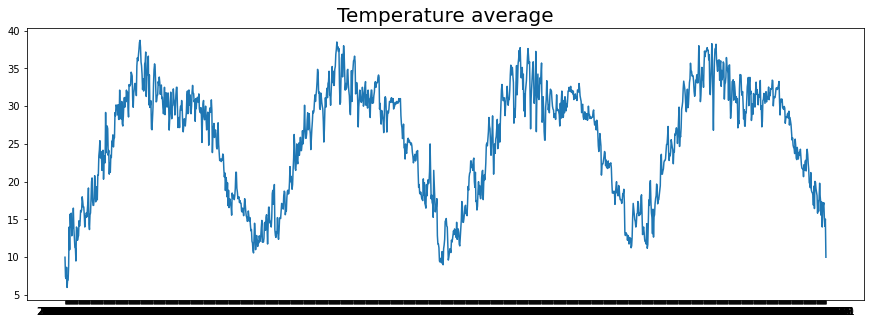

In [13]:
dates = data_train['date'].values
temp = data_train['meantemp'].values

plt.figure(figsize = (15, 5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize = 20);

Tuliskan fungsi di bawah yang dapat mengubah data kita menjadi format yang dapat diterima oleh model. Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

Selanjutnya untuk arsitektur model gunakan 2 buah layer LSTM. Ketika menggunakan 2 buah layer LSTM, perhatikan bahwa layer pertama harus memiliki parameter return_sequences yang bernilai True.

In [15]:
train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

Lalu pada optimizer, kita akan menggunakan parameter learning rate dan momentum seperti di bawah. Loss function yang dapat dicoba untuk ini adalah Huber yang merupakan salah satu loss function yang umum digunakan pada kasus time series.  Serta metrik yang digunakan untuk mengevaluasi model adalah MAE.

In [16]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
15/15 [==============================] - 14s 114ms/step - loss: 25.4501 - mae: 25.9501
Epoch 2/100
15/15 [==============================] - 2s 107ms/step - loss: 25.4136 - mae: 25.9136
Epoch 3/100
15/15 [==============================] - 2s 108ms/step - loss: 25.3673 - mae: 25.8673
Epoch 4/100
15/15 [==============================] - 2s 106ms/step - loss: 25.3235 - mae: 25.8235
Epoch 5/100
15/15 [==============================] - 2s 105ms/step - loss: 25.2852 - mae: 25.7852
Epoch 6/100
15/15 [==============================] - 2s 108ms/step - loss: 25.2492 - mae: 25.7492
Epoch 7/100
15/15 [==============================] - 2s 106ms/step - loss: 25.2120 - mae: 25.7120
Epoch 8/100
15/15 [==============================] - 2s 106ms/step - loss: 25.1722 - mae: 25.6722
Epoch 9/100
15/15 [==============================] - 2s 111ms/step - loss: 25.1291 - mae: 25.6291
Epoch 10/100
15/15 [==============================] - 3s 210ms/step - loss: 25.0824 - mae: 25.5824
Epoch 11/100
15/15

Hasil dari pelatihan menunjukkan model memiliki MAE yang relatif rendah dibandingkan skala data.